# BIND Paper Analysis: Overview & Visualization

This notebook provides an introduction to the BIND (Baryonic INverse Diffusion) method and visualizes the key components of our analysis pipeline.

## Contents
1. [Setup & Imports](#1-setup--imports)
2. [The BIND Process Illustrated](#2-the-bind-process-illustrated)
3. [Full Simulation Maps](#3-full-simulation-maps)
4. [Halo Cutout Examples](#4-halo-cutout-examples)
5. [Hydro-Replacement Comparison](#5-hydro-replacement-comparison)

---

## 1. Setup & Imports

In [ ]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Local utilities
import sys
sys.path.insert(0, '..')
from paper_notebooks.paper_utils import (
    setup_plotting_style, 
    BOX_SIZE, GRID_SIZE, PIXEL_TO_MPC, MODEL_NAME,
    plot_simulation_map, add_halo_circles, 
    create_figure_with_colorbar, savefig_paper
)

# Apply publication-quality plot settings
setup_plotting_style()

# Ensure output directory exists
import os
os.makedirs('paper_plots', exist_ok=True)

## 2. The BIND Process Illustrated

BIND transforms dark matter-only (DMO) simulation halos into baryonic (hydrodynamic) halos using a diffusion-based generative model. The key steps are:

1. **Input**: DMO simulation with identified halos
2. **Halo Extraction**: Extract cutouts around each halo
3. **Generation**: Apply trained diffusion model to generate baryonic components
4. **Assembly**: Replace original DMO halos with generated baryonic halos

### 2.1 Load Example Simulation Data

In [2]:
# Load a CV simulation for demonstration
SIM_NUM = 0
BASE_PATH = '/mnt/home/mlee1/ceph/BIND2d_new/CV'

# Load full maps
snap_path = f'{BASE_PATH}/sim_{SIM_NUM}/snap_90'
full_hydro = np.load(f'{snap_path}/full_hydro.npy')
full_dm = np.load(f'{snap_path}/sim_grid.npy')

# Load halo data
halo_path = f'{snap_path}/mass_threshold_13'
hydro_cutouts = np.load(f'{halo_path}/hydro_cutouts.npy')
dmo_cutouts = np.load(f'{halo_path}/dmo_cutouts.npy')
halo_metadata = np.load(f'{halo_path}/halo_metadata.npz', allow_pickle=True)

# Load hydro-replacement map
hydro_replace_path = f'/mnt/home/mlee1/ceph/BIND2d/hydro_replace/CV/sim_{SIM_NUM}/hydro_replace'
full_hydro_replace = np.load(f'{hydro_replace_path}/final_map_hydro_replace.npy')

print(f"Loaded simulation {SIM_NUM}:")
print(f"  Full DM map: {full_dm.shape}")
print(f"  Full Hydro map: {full_hydro.shape}")
print(f"  Number of halos: {len(dmo_cutouts)}")
print(f"  Hydro cutout shape: {hydro_cutouts.shape}")

Loaded simulation 0:
  Full DM map: (1024, 1024)
  Full Hydro map: (1024, 1024)
  Number of halos: 45
  Hydro cutout shape: (45, 3, 128, 128)


In [3]:
# Convert halo coordinates to physical units (Mpc/h)
center_pixels = np.asarray(halo_metadata['center_pixels'])  # (N, 2) in pixels
radii_kpc = np.asarray(halo_metadata['radii'])  # R200c in kpc

# Convert to Mpc
centers_mpc = center_pixels * PIXEL_TO_MPC
radii_mpc = radii_kpc / 1000  # kpc -> Mpc
radii_pixels = radii_kpc / 1000 * GRID_SIZE / BOX_SIZE  # for plotting cutouts

print(f"Halo R200c range: {radii_kpc.min():.1f} - {radii_kpc.max():.1f} kpc")
print(f"Halo R200c range: {radii_mpc.min():.3f} - {radii_mpc.max():.3f} Mpc/h")

Halo R200c range: 350.6 - 1045.2 kpc
Halo R200c range: 0.351 - 1.045 Mpc/h


## 3. Full Simulation Maps

Visualize the complete simulation box showing the dark matter distribution with identified halos.

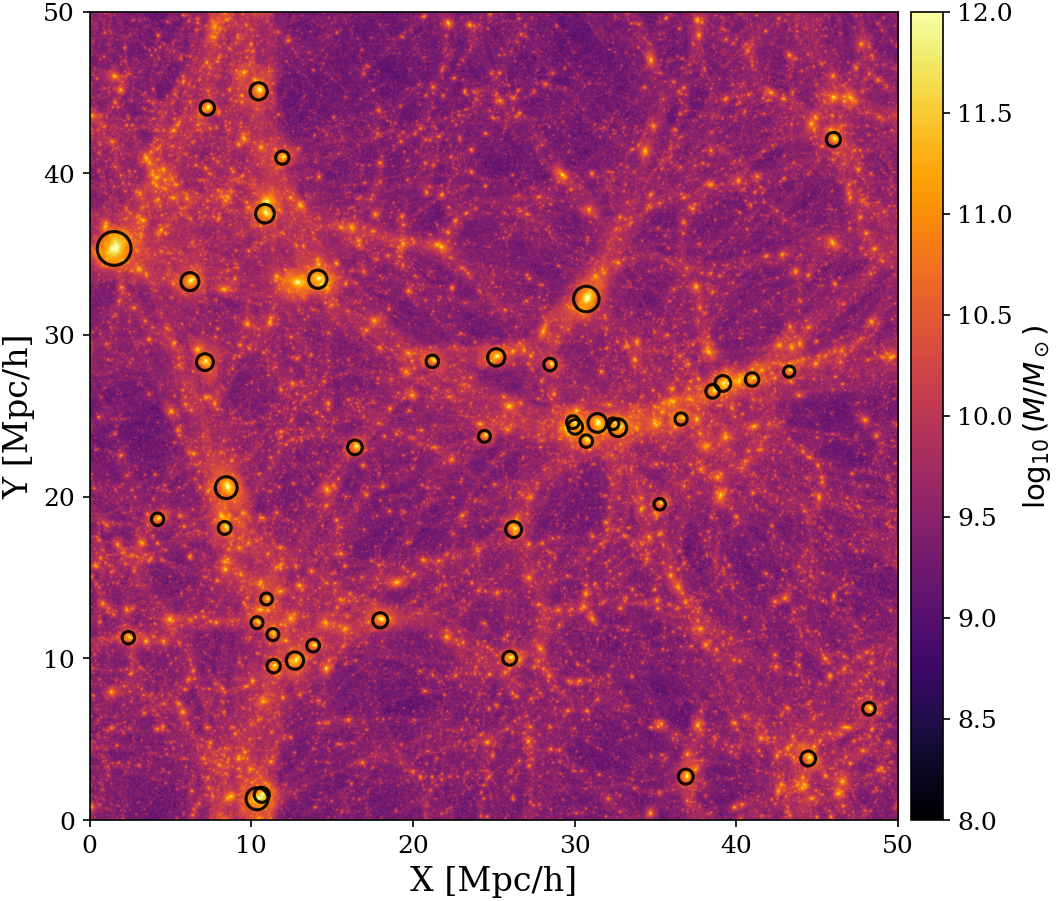

In [4]:
# Figure 1: Dark matter simulation with halo positions
fig, ax, cax = create_figure_with_colorbar(figsize=(7, 7))

# Plot DM field
im = ax.imshow(np.log10(full_dm).T, cmap='inferno', vmin=8, vmax=12, 
               extent=[0, BOX_SIZE, 0, BOX_SIZE], origin='lower')

# Overlay halo circles
add_halo_circles(ax, centers_mpc, radii_mpc, edgecolor='black')

# Labels
ax.set_xlabel('X [Mpc/h]', fontsize=16)
ax.set_ylabel('Y [Mpc/h]', fontsize=16)
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)

# Colorbar
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)

savefig_paper(fig, 'DM_sim.pdf')
plt.show()

## 4. Halo Cutout Examples

Compare DMO vs Hydro cutouts for individual halos to illustrate the baryonic effects BIND learns to model.

In [5]:
# Select example halo
HALO_IDX = 2

# Compute extent in Mpc for this cutout (128 pixels centered on halo)
cutout_half_size = 64 * PIXEL_TO_MPC  # 64 pixels on each side
cx, cy = centers_mpc[HALO_IDX]
extent = [cx - cutout_half_size, cx + cutout_half_size, 
          cy - cutout_half_size, cy + cutout_half_size]

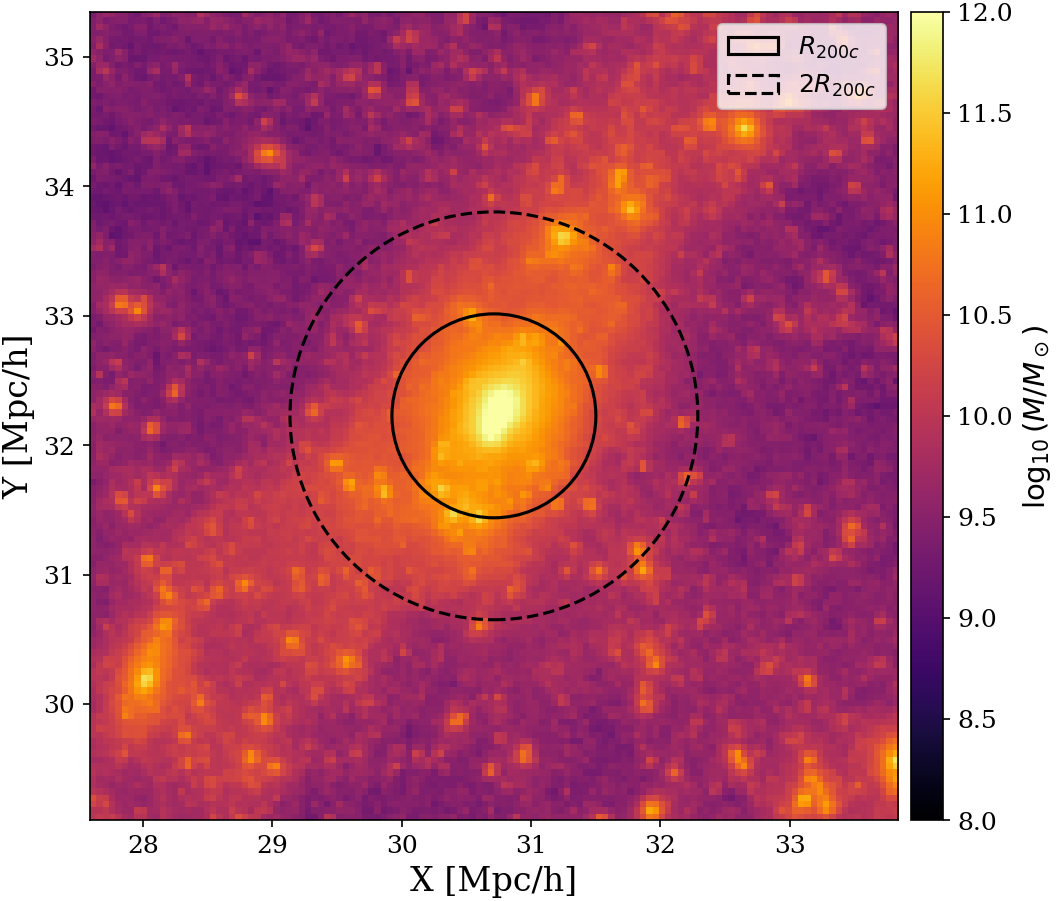

In [6]:
# Figure 2: DMO halo cutout
fig, ax, cax = create_figure_with_colorbar(figsize=(7, 7))

im = ax.imshow(np.log10(dmo_cutouts[HALO_IDX]).T, origin='lower', 
               cmap='inferno', vmin=8, vmax=12, extent=extent)

# Add R200c and 2×R200c circles
circ_r200 = patches.Circle((cx, cy), radius=radii_mpc[HALO_IDX], 
                           edgecolor='black', facecolor='none', 
                           linewidth=1.5, label=r'$R_{200c}$')
circ_2r200 = patches.Circle((cx, cy), radius=2*radii_mpc[HALO_IDX], 
                            edgecolor='black', facecolor='none', 
                            linewidth=1.5, linestyle='--', label=r'$2R_{200c}$')
ax.add_patch(circ_r200)
ax.add_patch(circ_2r200)

# Labels
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)
ax.set_xlabel('X [Mpc/h]', fontsize=16)
ax.set_ylabel('Y [Mpc/h]', fontsize=16)
ax.legend(loc='upper right')

savefig_paper(fig, 'dmo_cutout.pdf')
plt.show()

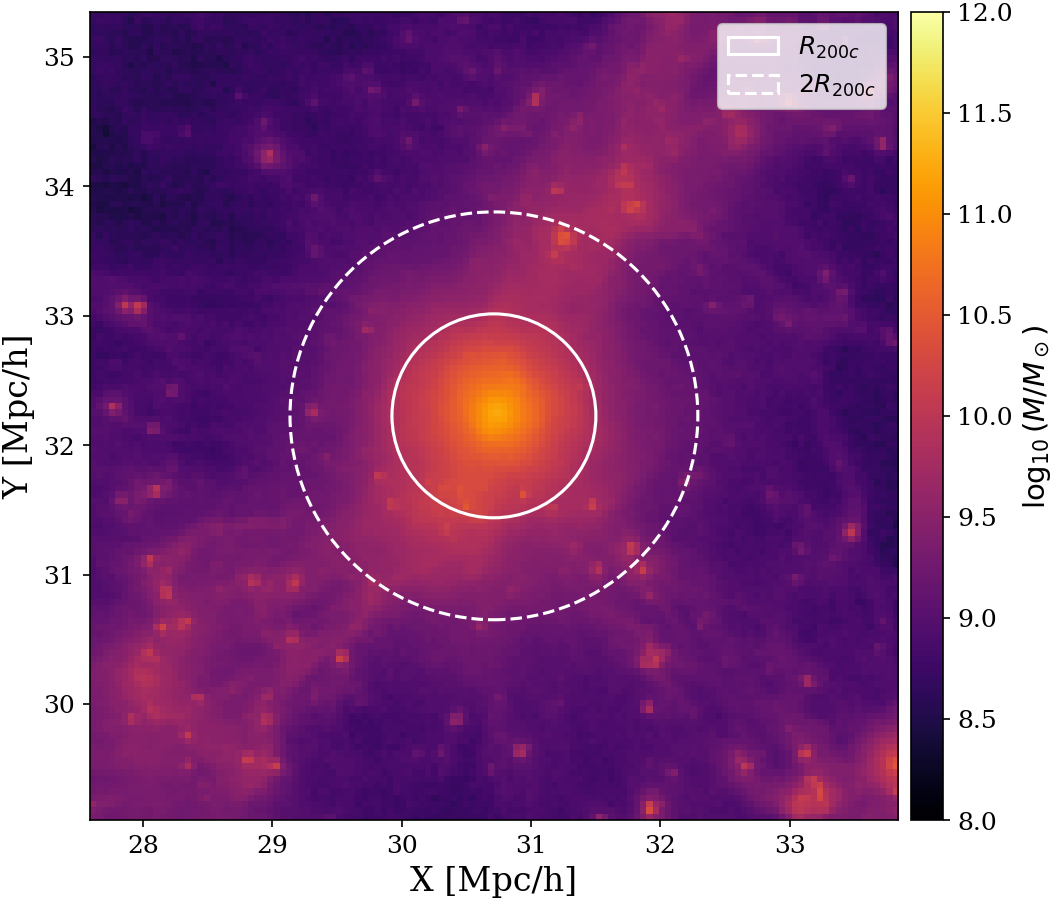

In [7]:
# Figure 3: Hydro gas cutout (channel 1)
fig, ax, cax = create_figure_with_colorbar(figsize=(7, 7))

# hydro_cutouts shape: (n_halos, 3, 128, 128) where channels are [DM, gas, stars]
im = ax.imshow(np.log10(hydro_cutouts[HALO_IDX, 1]).T, origin='lower', 
               cmap='inferno', vmin=8, vmax=12, extent=extent)

# Add circles
circ_r200 = patches.Circle((cx, cy), radius=radii_mpc[HALO_IDX], 
                           edgecolor='white', facecolor='none', 
                           linewidth=1.5, label=r'$R_{200c}$')
circ_2r200 = patches.Circle((cx, cy), radius=2*radii_mpc[HALO_IDX], 
                            edgecolor='white', facecolor='none', 
                            linewidth=1.5, linestyle='--', label=r'$2R_{200c}$')
ax.add_patch(circ_r200)
ax.add_patch(circ_2r200)

# Labels
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$\log_{10}(M / M_\odot)$', fontsize=14)
ax.set_xlabel('X [Mpc/h]', fontsize=16)
ax.set_ylabel('Y [Mpc/h]', fontsize=16)
ax.legend(loc='upper right')

savefig_paper(fig, 'hydro_gas_cutout.pdf')
plt.show()

## 5. Hydro-Replacement Comparison

Visualize the fractional difference between the hydro-replaced map and the original DMO map.

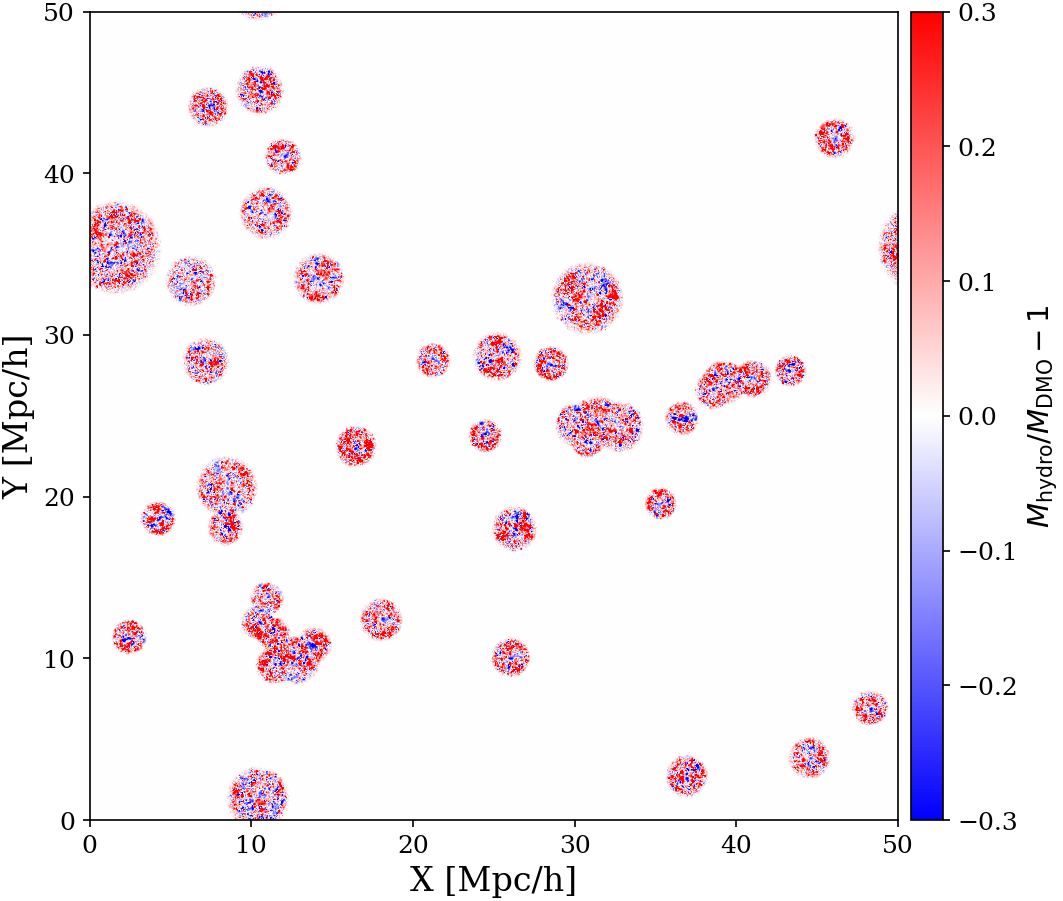

In [8]:
# Figure 4: Hydro-replacement ratio map
fig, ax, cax = create_figure_with_colorbar(figsize=(7, 7))

# Compute fractional difference
ratio_map = full_hydro_replace / full_dm - 1

im = ax.imshow(ratio_map.T, cmap='bwr', vmin=-0.3, vmax=0.3, 
               extent=[0, BOX_SIZE, 0, BOX_SIZE], origin='lower')

# Labels
ax.set_xlabel('X [Mpc/h]', fontsize=16)
ax.set_ylabel('Y [Mpc/h]', fontsize=16)
ax.set_xlim(0, BOX_SIZE)
ax.set_ylim(0, BOX_SIZE)

# Colorbar
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r'$M_{\rm hydro} / M_{\rm DMO} - 1$', fontsize=14)

savefig_paper(fig, 'hydro_replace.pdf')
plt.show()

### 5.1 Halo-Level Comparison: BIND vs Hydro

Compare BIND-generated halos with true hydrodynamic halos.

In [ ]:
# Load generated halos
gen_path = f'{halo_path}/{MODEL_NAME}/generated_halos.npz'
generated_halos = np.load(gen_path, allow_pickle=True)
gen_cutouts = generated_halos['generated']  # Shape: (n_halos, 10, 3, 128, 128)
radii = generated_halos['radii']

print(f"Generated halos shape: {gen_cutouts.shape}")
print(f"  - {gen_cutouts.shape[0]} halos")
print(f"  - {gen_cutouts.shape[1]} realizations per halo")
print(f"  - {gen_cutouts.shape[2]} channels [DM, gas, stars]")

Generated halos shape: (45, 10, 3, 128, 128)
  - 45 halos
  - 10 realizations per halo
  - 3 channels [DM, gas, stars]


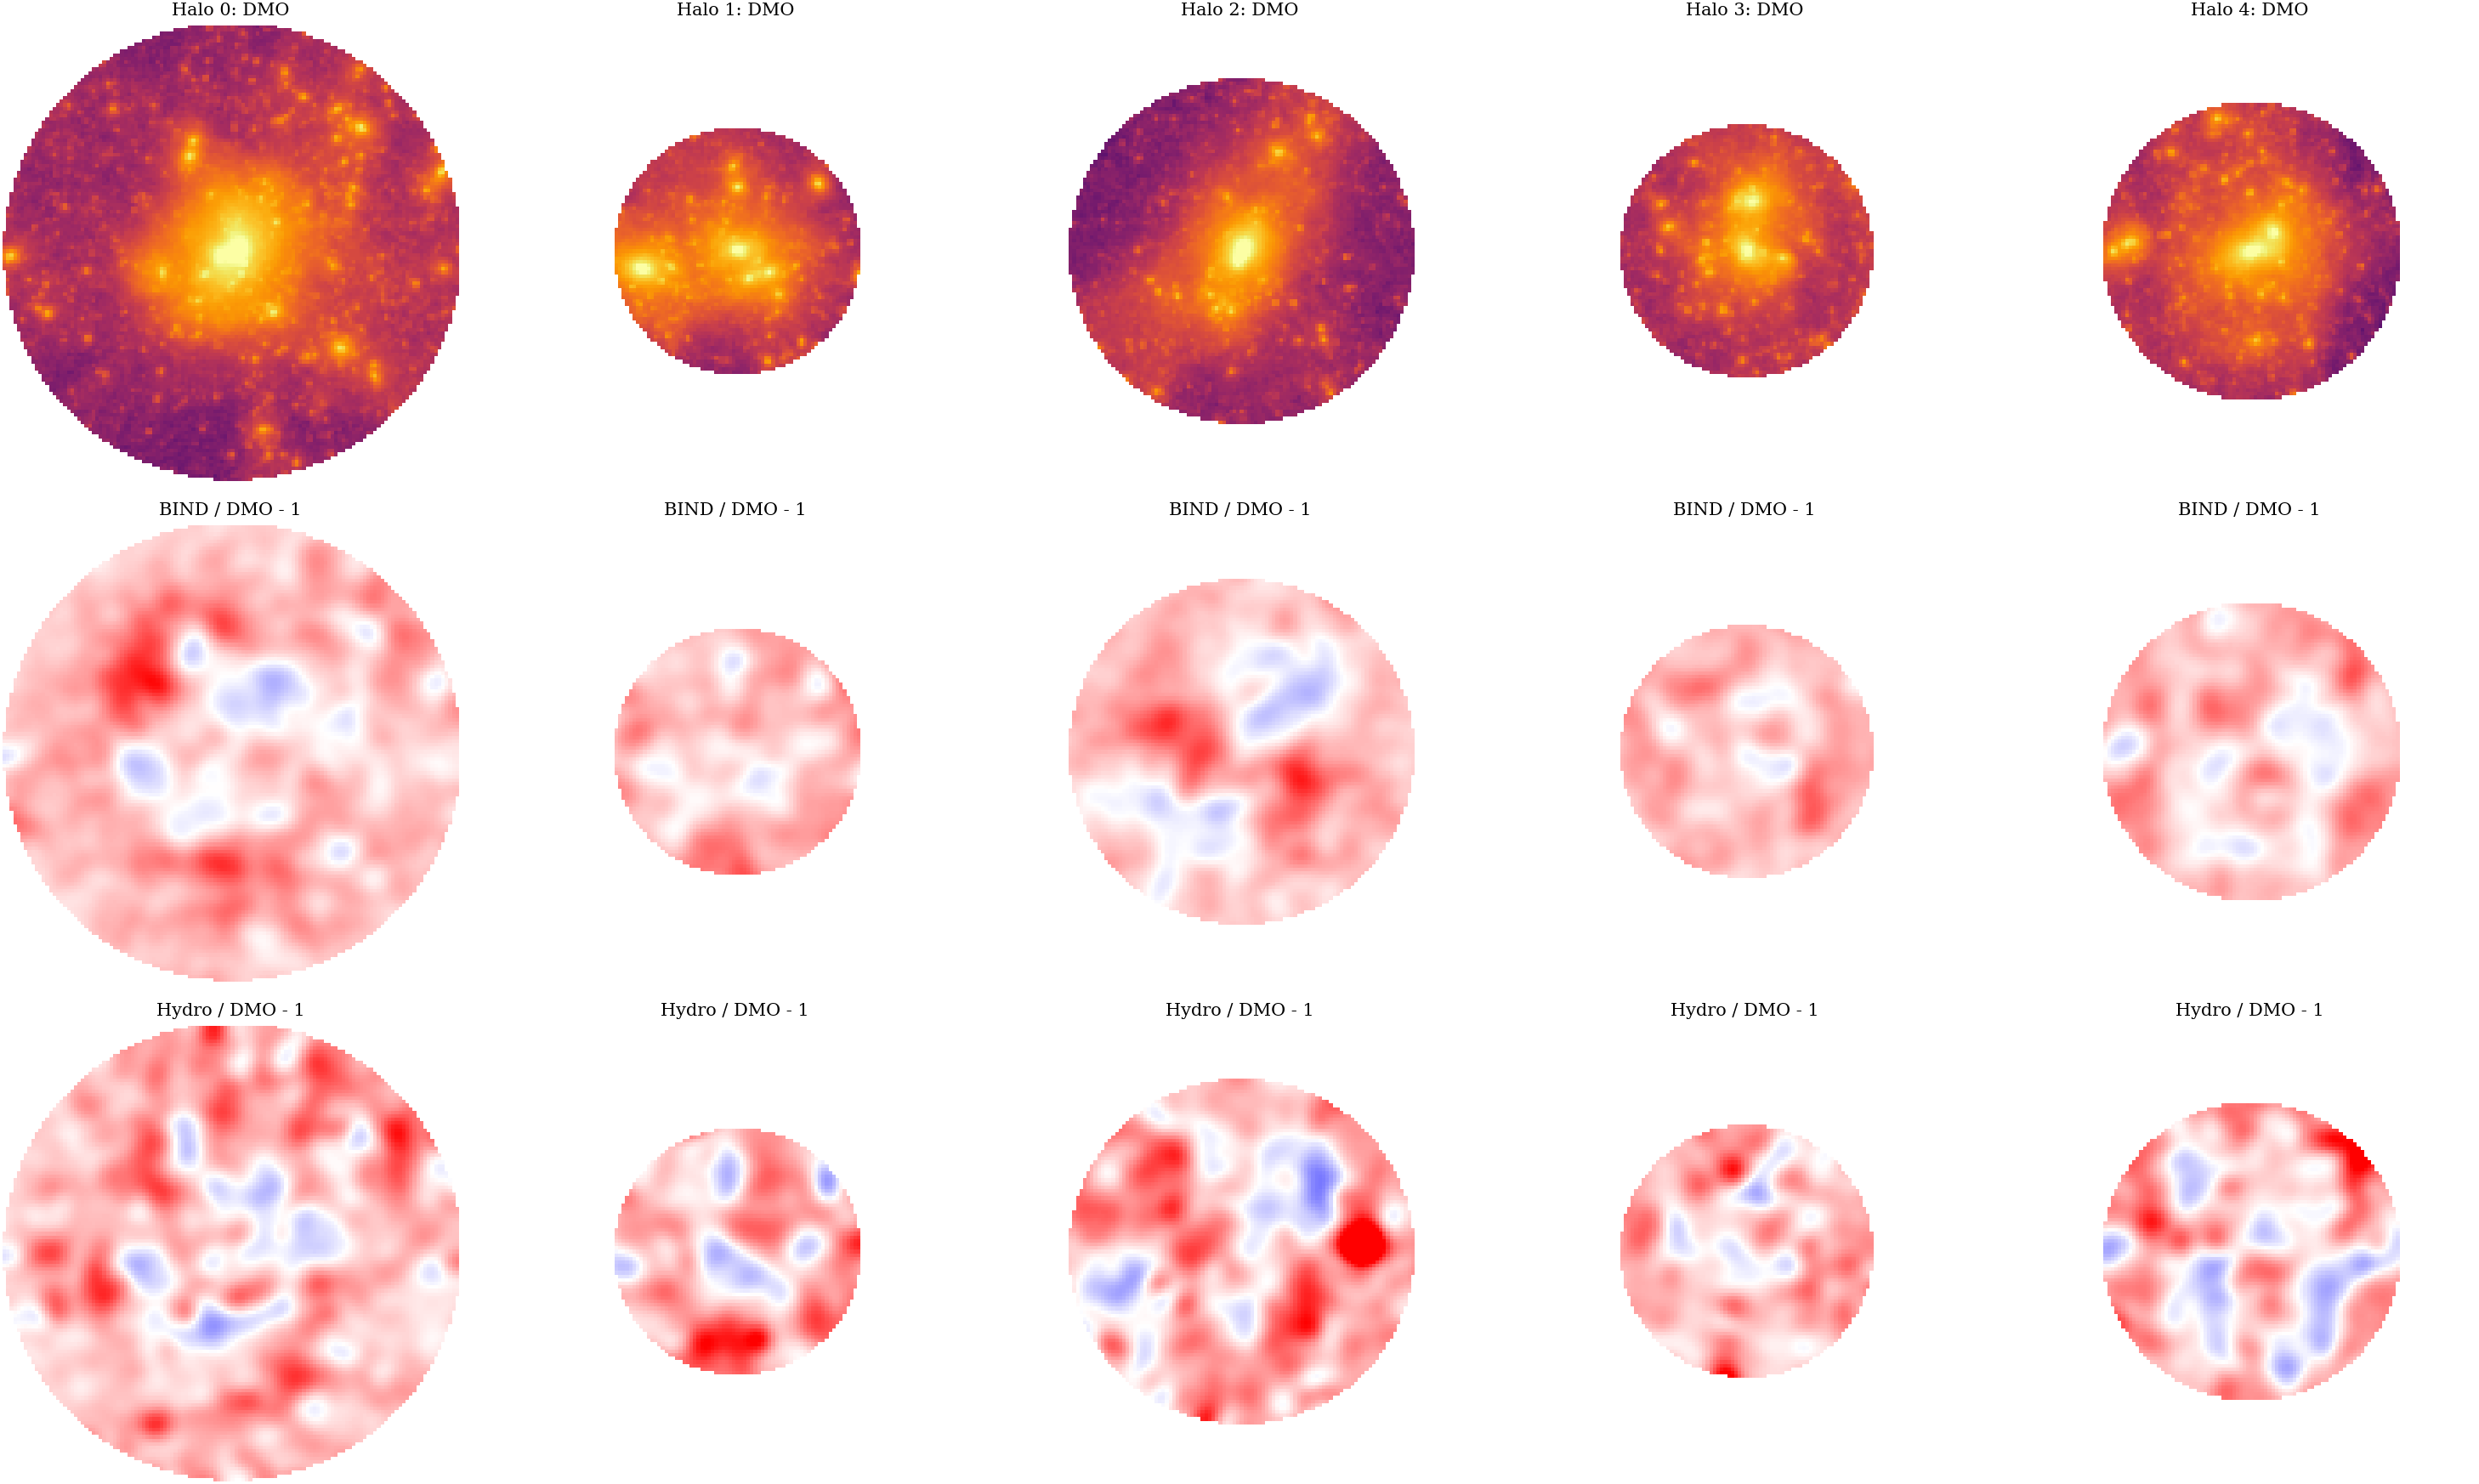

In [10]:
from scipy.ndimage import gaussian_filter

# Figure 5: Multi-halo comparison - DMO, BIND, Hydro
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i in range(5):
    # Get R200c in pixels for masking
    r200_pixels = radii[i] / (BOX_SIZE / GRID_SIZE) / 1000
    mask_radius = 3 * r200_pixels
    
    # Create circular mask at 3×R200
    center = 64
    y, x = np.ogrid[:128, :128]
    mask = np.sqrt((x - center)**2 + (y - center)**2) <= mask_radius
    
    # Row 1: DMO
    ax = axes[0, i]
    dm_masked = np.copy(dmo_cutouts[i])
    dm_masked[~mask] = np.nan
    im = ax.imshow(np.log10(dm_masked).T, origin='lower', cmap='inferno', vmin=8, vmax=12)
    ax.set_title(f'Halo {i}: DMO', fontsize=10)
    ax.axis('off')
    
    # Row 2: BIND/DMO - 1 (mean over realizations)
    ax = axes[1, i]
    bind_total = gen_cutouts[i].sum(axis=1).mean(axis=0)  # Mean over realizations, sum channels
    diff_bind = bind_total.T / dmo_cutouts[i].T - 1
    diff_bind_smooth = gaussian_filter(diff_bind, sigma=3)
    diff_bind_masked = np.copy(diff_bind_smooth)
    diff_bind_masked[~mask.T] = np.nan
    ax.imshow(diff_bind_masked, origin='lower', cmap='bwr', vmin=-0.3, vmax=0.3)
    ax.set_title('BIND / DMO - 1', fontsize=10)
    ax.axis('off')
    
    # Row 3: Hydro/DMO - 1
    ax = axes[2, i]
    hydro_total = hydro_cutouts[i].sum(axis=0)
    diff_hydro = hydro_total.T / dmo_cutouts[i].T - 1
    diff_hydro_smooth = gaussian_filter(diff_hydro, sigma=3)
    diff_hydro_masked = np.copy(diff_hydro_smooth)
    diff_hydro_masked[~mask.T] = np.nan
    ax.imshow(diff_hydro_masked, origin='lower', cmap='bwr', vmin=-0.3, vmax=0.3)
    ax.set_title('Hydro / DMO - 1', fontsize=10)
    ax.axis('off')

plt.tight_layout()
savefig_paper(fig, 'halo_mass_differences_overview.pdf')
plt.show()

---

## Summary

This notebook demonstrated:

1. **BIND Pipeline Overview**: How dark matter halos are identified, extracted, processed, and assembled back into full maps
2. **Simulation Visualization**: Full simulation box with halo positions marked
3. **Halo Cutouts**: Comparison of DMO vs hydrodynamic halo structure
4. **Baryonic Effects**: Mass redistribution patterns (gas ejection, stellar formation) captured by BIND

**Next notebooks:**
- `02_power_spectrum_analysis.ipynb`: Statistical analysis of matter power spectra
- `03_density_profile_analysis.ipynb`: Radial density profile comparisons
- `04_integrated_mass_analysis.ipynb`: Total mass within virial radii
- `05_ssim_analysis.ipynb`: Structural similarity metrics